# Model for Seasonal Inventory 

In [1]:
# (If not already installed) Install Google's OR-Tools for optimization
# !pip install ortools

In [2]:
import pandas as pd
from ortools.linear_solver import pywraplp

In [3]:
# Set time periods and initial inventory for one product
MONTHS = {0: 'July 2021',
          1: 'August 2021',
          2: 'September 2021',
          3: 'October 2021',
          4: 'November 2021',
          5: 'December 2021',
          6: 'January 2022',
          7: 'February 2022',
          8: 'March 2022',
          9: 'April 2022',
          10: 'May 2022',
          11: 'June 2022'}
NUM_MONTHS = len(MONTHS)
INITIAL_INVENTORY = 50

# The capacity can vary by month depending on staffing levels, vacations, etc.
MAX_CAPACITY = {0: 250,
                1: 250,
                2: 250,
                3: 310,
                4: 310,
                5: 310,
                6: 310,
                7: 310,
                8: 310,
                9: 310,
                10: 310,
                11: 250} 

# The demand in time periods 4 and 5 exceeds the capacity available
DEMAND = {0: 100,
          1: 120,
          2: 250,
          3: 300,
          4: 330,
          5: 450,
          6: 300,
          7: 250,
          8: 250,
          9: 220,
          10: 120,
          11: 100}

# Not accounting for overtime with capacity increase in this simplified model
INVENTORY_HOLDING_COST = 1
VARIABLE_COST = {0: 10,
                 1: 10,
                 2: 10,
                 3: 10,
                 4: 10,
                 5: 10,
                 6: 10,
                 7: 10,
                 8: 10,
                 9: 10,
                 10: 10,
                 11: 10} 

## Google OR-Tools formulation

In [4]:
# Create the mip solver with the SCIP backend
solver = pywraplp.Solver.CreateSolver('SCIP')

### Declare Decision Variables

In [5]:
# p is the units p produced in each period
p = {}
for m in range(NUM_MONTHS):
    p[m] = solver.IntVar(0, solver.infinity(), 'produced_inventory')
    
# b is the inventory at the beginning of each periond
b = {}
for m in range(NUM_MONTHS):
    b[m] = solver.IntVar(0, solver.infinity(), 'beginning_inventory')

# e is the inventory at the end of each period
e = {}
for m in range(NUM_MONTHS):
    e[m] = solver.IntVar(0, solver.infinity(), 'ending_inventory')
    
print('Number of variables =', solver.NumVariables())

Number of variables = 36


### Add Constraints
\begin{equation}
\text{beginning inventory}_{m} = \text{ending inventory}_{m+1} \quad \forall m > 0\in \text{months}
\end{equation}

\begin{equation}
\text{beginning inventory}_{m} + \text{production}_{m} = \text{demand}_{m} + \text{ending inventory}_{m} \quad \forall m \in \text{months}
\end{equation}

\begin{equation}
\text{production}_{m} \leq \text{capacity}_{m} \quad \forall m \in \text{months}
\end{equation}

\begin{equation}
\text{ending inventory}_{m} \geq \text{50} \quad \forall m \in \text{months}
\end{equation}

\begin{equation}
\text{production}_{m} \geq \text{alpha} \cdot \text{production}_{m-1} \quad \forall m > 0\in \text{months}
\end{equation}

\begin{equation}
\text{production}_{m-1} \geq \text{alpha} \cdot \text{production}_{m} \quad \forall m > 0\in \text{months}
\end{equation}


In [6]:
# Setup for the initial month
solver.Add(b[0] == INITIAL_INVENTORY)
solver.Add(b[0] + p[0] == DEMAND[0] + e[0])
solver.Add(p[0] <= MAX_CAPACITY[0])
solver.Add(e[0] >= 50)

# Setup for subsequent months
for m in range(1, NUM_MONTHS):
    solver.Add(b[m] == e[m-1])
    solver.Add(b[m] + p[m] == DEMAND[m] + e[m])
    solver.Add(p[m] <= MAX_CAPACITY[m])
    solver.Add(e[m] >= 50)
    
# production smoothing, lessens production changes from one period to the next 
alpha = 0.8
for m in range(1, NUM_MONTHS):
    solver.Add(p[m] >= alpha * p[m-1])
    solver.Add(p[m-1] >= alpha * p[m])

print('Number of constraints =', solver.NumConstraints())

Number of constraints = 70


### Objective
\begin{equation}
\text{Min} \quad Z = \sum_{m \in Months} {production cost}_{m} \cdot \text{production}_{m} + {storage cost}_{m} \cdot \text{average storage}_{m} 
\end{equation}


In [7]:
# Calculate costs for the objective and run the solver
total_variable_cost = []
for v in VARIABLE_COST:
    total_variable_cost.append(VARIABLE_COST[v]*p[v])
sum_variable_cost = sum(total_variable_cost)

inventory_holding_cost = []
for m in MONTHS:
    inventory_holding_cost.append(INVENTORY_HOLDING_COST*((e[m]+b[m])/2))
sum_inventory_cost = sum(inventory_holding_cost)

total_cost = sum_inventory_cost + sum_variable_cost
solver.Minimize(total_cost)
status = solver.Solve()

if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
    print('Total cost = ', round(solver.Objective().Value()), '\n')
    print('Solver wall time = ', solver.wall_time())
    print(('Problem solved in %d iterations' % solver.iterations()))
else:
    print('There was not an optimal solution')

Total cost =  29812 

Solver wall time =  88
Problem solved in 57 iterations


In [8]:
inventory_results = pd.DataFrame(columns=['Month', 
                                          'Beginning', 
                                          'Produced', 
                                          'Demand', 
                                          'Ending', 
                                          'Capacity',
                                          'Unutilized Capacity'])
for a in b: 
    inventory_results.loc[a] = [MONTHS[a], 
                                b[a].solution_value(), 
                                p[a].solution_value(), 
                                DEMAND[a], 
                                e[a].solution_value(),
                                MAX_CAPACITY[a],
                                p[a].solution_value() - MAX_CAPACITY[a]]
inventory_results

,Month,Beginning,Produced,Demand,Ending,Capacity,Unutilized Capacity
0,July 2021,50.0,165.0,100,115.0,250,-85.0
1,August 2021,115.0,205.0,120,200.0,250,-45.0
2,September 2021,200.0,250.0,250,200.0,250,0.0
3,October 2021,200.0,310.0,300,210.0,310,0.0
4,November 2021,210.0,310.0,330,190.0,310,0.0
5,December 2021,190.0,310.0,450,50.0,310,0.0
6,January 2022,50.0,309.0,300,59.0,310,-1.0
7,February 2022,59.0,291.0,250,100.0,310,-19.0
8,March 2022,100.0,233.0,250,83.0,310,-77.0
9,April 2022,83.0,187.0,220,50.0,310,-123.0


<module 'matplotlib.pyplot' from '/Users/alberta/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

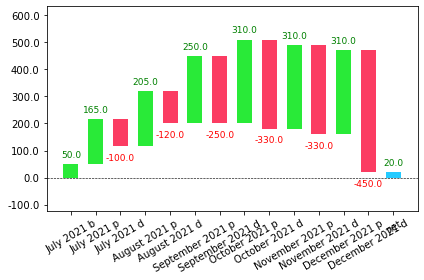

In [9]:
# !pip install waterfallcharts
import waterfall_chart
# waterfall_chart.plot(brent.index, brent['delta'])
waterfall_chart.plot(['July 2021 b', 'July 2021 p', 'July 2021 d',
                      'August 2021 p', 'August 2021 d',
                      'September 2021 p', 'September 2021 d',
                      'October 2021 p', 'October 2021 d',
                      'November 2021 p', 'November 2021 d',
                      'December 2021 p', 'December 2021 d'],
                     [50, 165, -100,
                          205, -120,
                          250, -250,
                          310, -330,
                          310, -330,
                          310, -450
                     ])

### The solution makes sense
The minimum cost of production for the predicted demand is 27,400 = (sum(DEMAND.values()) - INITIAL_INVENTORY) * 10.  However, additional constraints such as minimal inventory levels, production smoothing, and inventory holding cost result in a higher cost.

### Model Limitations
1. The validity of the model is only to model prior and up to the peak demand
    * The data used in the model was designed to help understand how much seasonal inventory to build before the busy season (in this case from September to March).
    * As you can see, the results wound down inventory to ZERO at the end of the data supplied.
    * Since the model is not intended to be used to model production beyond the seasonal inventory preparation until the peak in December, when sharing the results I would suggest to share only those results through December.
2. The model does not include the possibility of increasing capacity through overtime, although the variable cost structure is intended to ease the transition for such scenarios.
3. The model does not take into account the cost of storing inventory.  The main cost included is the cost of producing inventory.
4. The model does not take into account the uncertainty of demand.  
5. The model does not take into account inventory capacity, throughput capacity, or loading dock capacity.  This model only takes into account production capacity.